#### LEVEL 3: Single Burst and Unit-level Relationships

(1) Single Burst Raster and Unit Order
    - Which units fired during a single burst?
    - When did they peak?
    - What is their temporal order?
    - Can I visualize a clear activation sequence?
        - IFR matrix for a burst and sort units by peak firing rate within that window.

(2)  Relative Timing and Firing Order
    Goals:
        Analyze when each unit fires relative to the population burst peak across bursts
        Add temporal precision to burst structure metrics for rank order correlations and functional role identification.
            - How early or late does a unit fire?
            - Do some units always fire early? Are they consistent?
            - Can we detect sequential recruitment or backbone structures?
        Needs:
            A list of time differences between:
                Each unit's peak activity
                Population peak in the same burst
        Tasks:
            - Build histograms of activation order
            - Identify early-firing units
            - Compare temporal dispersion of units across bursts
        Ideas for expansion:
            - Group units by quartiles of firing latency
            - Track variability in firing latency across bursts
            - Identify scaffold units by consistently early peaks
            - Identify functional units by consistent temporal correlations across bursts


In [1]:
# --- Set up imports and paths ---
import sys
from pathlib import Path
import pandas as pd

# Set the project root so Python can find analysis_libs and others
project_root = Path("~/bioinformatics").expanduser().resolve()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Define the data directory
data_path = project_root / "data/extracted/maxtwo_newconfig1"

In [15]:
# Load 

# data_path = Path("~/bioinformatics/data/extracted/maxtwo_newconfig1").expanduser()
# from burst_analysis.loading import SpikeDataLoader

# loader = SpikeDataLoader(data_path)
# datasets = loader.load()  # dictionary of dataset_key -> SpikeData object

# print(f"Datasets loaded: {list(datasets.keys())}")

In [2]:
from projects.parkinsons.coordinator import OrchestratorPDx2

orc = OrchestratorPDx2()
print("Orchestrator initialized.")
print("Available dataset keys:", orc.list_datasets())

Switched to dataset: d0s2_Control
Set d0s2_Control as default dataset.
Orchestrator initialized.
Available dataset keys: ['d0s2_Control', 'd0s6_Treated', 'd6s2_Control', 'd6s6_Treated']


In [3]:
# load burst metrics and configuration settings for all samples
import pandas as pd
import json
from pathlib import Path

csv_path = Path("~/bioinformatics/projects/parkinsons/metrics.csv").expanduser()

def safe_json_load(x):
    """
    Safely loads JSON strings. Returns the original value if:
    - it's not a string
    - it's empty
    - it's invalid JSON
    """
    if isinstance(x, str):
        x = x.strip()
        if x.startswith("[") and x.endswith("]"):
            try:
                return json.loads(x)
            except json.JSONDecodeError:
                return x  # return raw string if parsing fails
    return x

if csv_path.exists():
    df = pd.read_csv(csv_path)

    # Attempt to load any JSON-like column safely
    for col in df.columns:
        if df[col].dtype == "object":
            df[col] = df[col].apply(safe_json_load)

    burst_extraction_records = df.to_dict(orient="records")
    print(f"Loaded {len(burst_extraction_records)} records from {csv_path}")
else:
    burst_extraction_records = []
    print("No saved metrics.csv found — starting fresh.")


Loaded 259 records from /Users/main_mac/bioinformatics/projects/parkinsons/metrics.csv


In [4]:
# --- 1) Define burst detection config (adjust per dataset if needed) ---
config = {
    "bin_size_ms": 5,
    "square_win_ms": 5,
    "gauss_win_ms": 17,
    "threshold_rms": 1.80,
    "min_dist_ms": 2000,
    "burst_edge_fraction": 0.25
}


# --- 2) Detect bursts for all datasets and cache results ---
burst_results = {}

for key in orc.list_datasets():
    detector = orc.get_burst_detector(key, config=config)
    result = detector.compute_population_rate_and_bursts()

    if result and result[-1]:
        burst_results[key] = {
            "detector": detector,
            "times": result[0],
            "smoothed_rate": result[1],
            "peaks": result[2],
            "peak_times": result[3],
            "bursts": result[4],
            "burst_windows": result[5]
        }
        print(f"{key}: {len(result[5])} bursts detected")
    else:
        print(f"{key}: No bursts detected (with current config)")


[dataset] peaks=466, duration=1865.5s, ≈14.99 bursts/min, bin_size_s=0.0050, thr=900.366 Hz
d0s2_Control: 466 bursts detected
[dataset] peaks=483, duration=1865.4s, ≈15.54 bursts/min, bin_size_s=0.0050, thr=491.665 Hz
d0s6_Treated: 483 bursts detected
[dataset] peaks=263, duration=904.9s, ≈17.44 bursts/min, bin_size_s=0.0050, thr=523.072 Hz
d6s2_Control: 263 bursts detected
[dataset] peaks=238, duration=904.9s, ≈15.78 bursts/min, bin_size_s=0.0050, thr=260.137 Hz
d6s6_Treated: 238 bursts detected


[dataset] peaks=404, duration=1865.5s, ≈12.99 bursts/min, bin_size_s=0.0050, thr=869.002 Hz


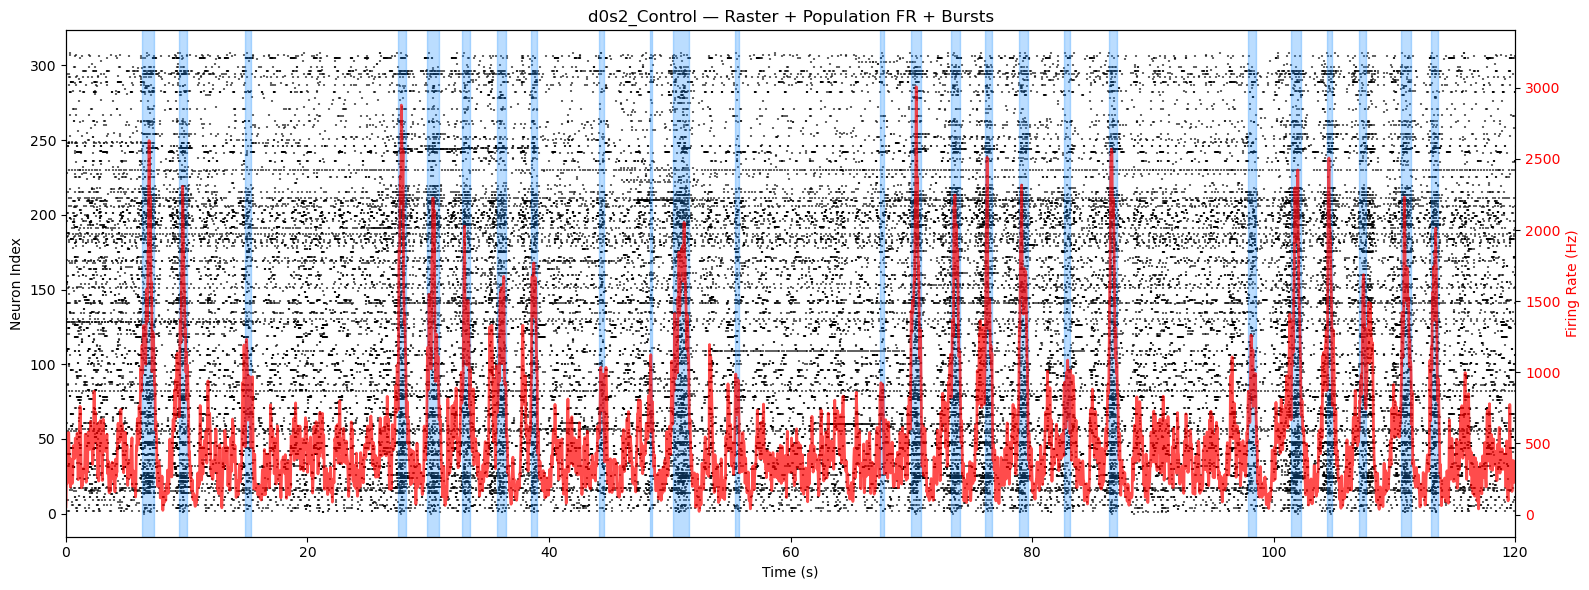

[dataset] peaks=462, duration=1865.4s, ≈14.86 bursts/min, bin_size_s=0.0050, thr=473.189 Hz


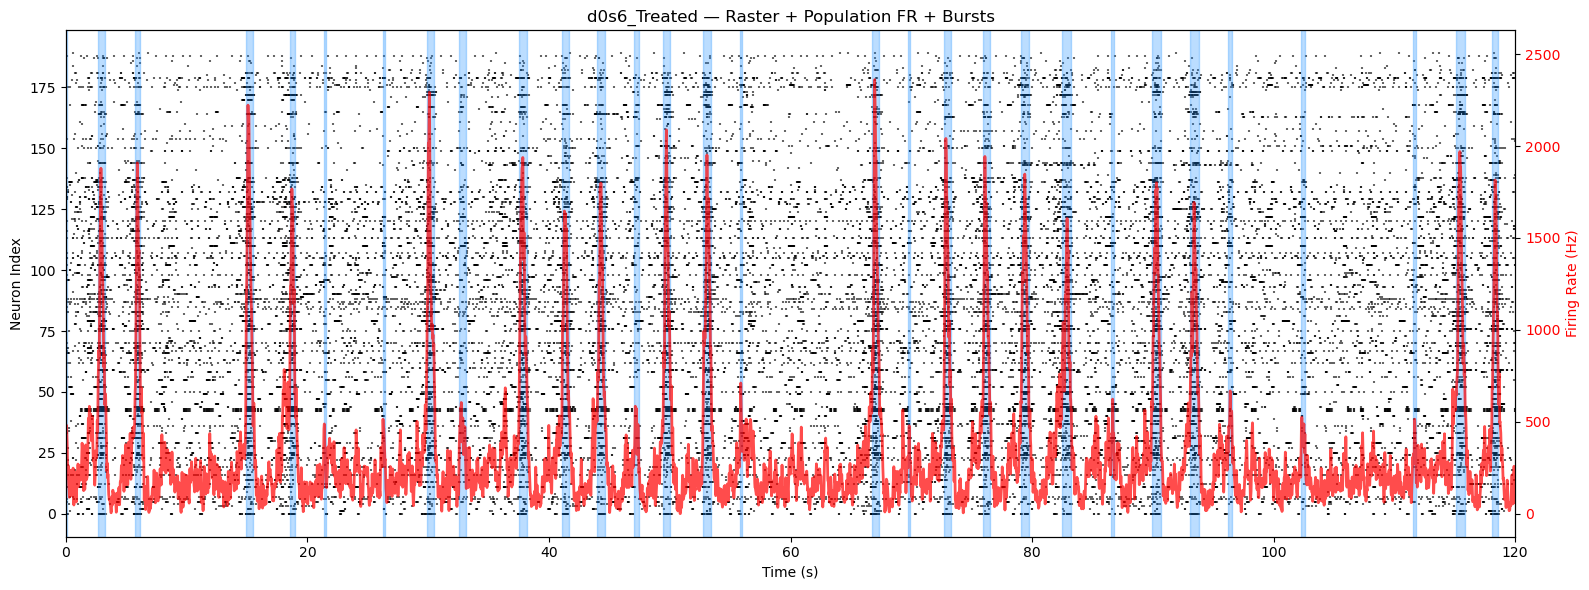

[dataset] peaks=219, duration=904.9s, ≈14.52 bursts/min, bin_size_s=0.0050, thr=504.343 Hz


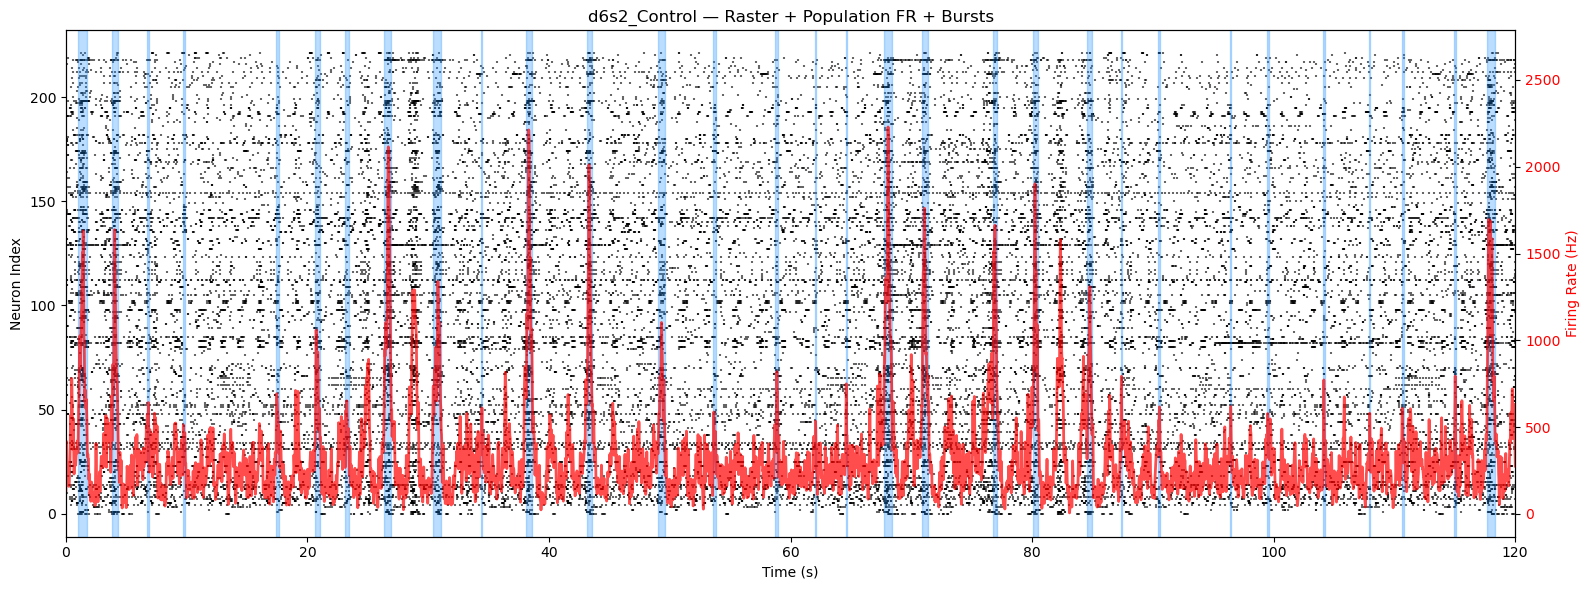

[dataset] peaks=222, duration=904.9s, ≈14.72 bursts/min, bin_size_s=0.0050, thr=248.909 Hz


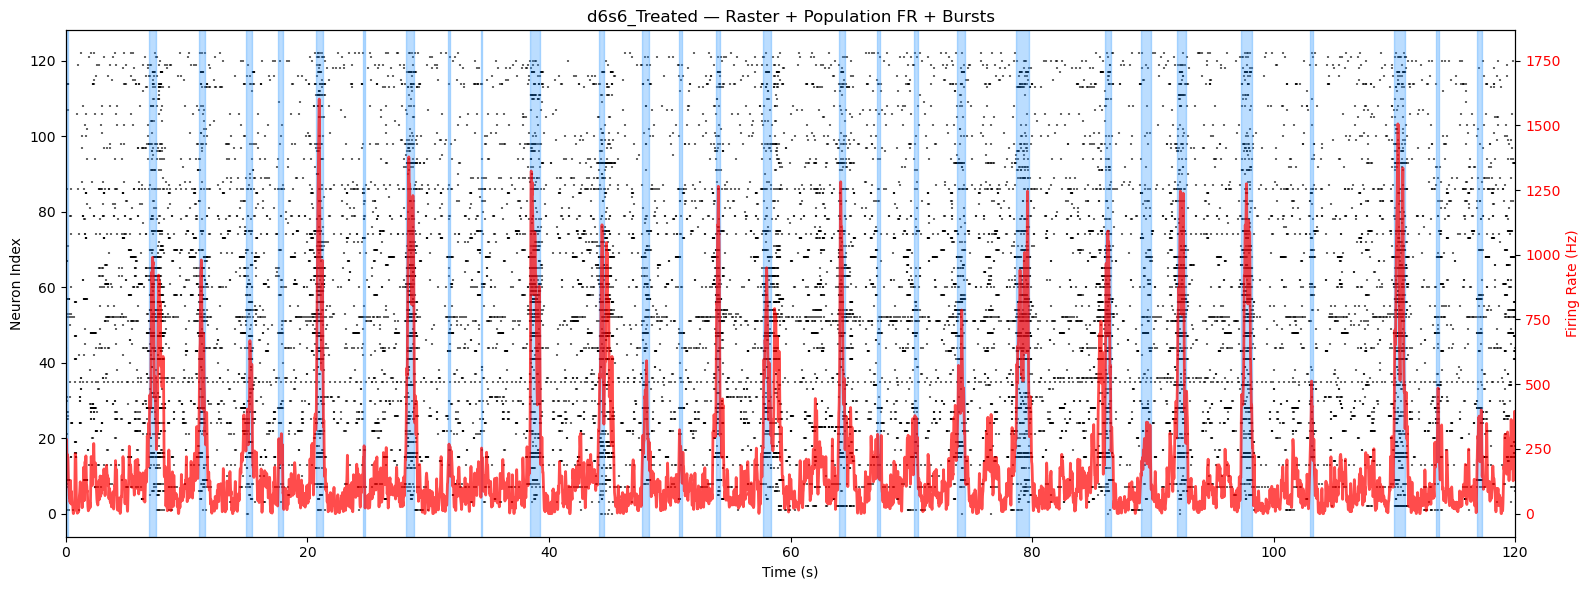

{'d0s2_Control': {'n_total_spikes': 1025794,
  'duration_s': np.float64(1865.4750000000001),
  'n_neurons': 309,
  'mean_rate_per_neuron': np.float64(1.7795583874605105),
  'n_total_bursts': 404,
  'mean_burst_dur': np.float64(0.6081064356435644),
  'std_burst_dur': np.float64(0.26259876229446033),
  'burst_rate_per_min': np.float64(12.994009568608531),
  'mean_IBI': np.float64(4.604168734491315),
  'n_pop_bursts_window': 404,
  'avg_peakFR_per_unit_window': np.float64(296.4401294498382),
  'avg_peakFR_per_unit_bin': np.float64(296.4401294498382),
  'n_bursts_at_time_0': 404,
  'mean_peakFR_at_time_0': np.float64(1856.5784651825873),
  'std_peakFR_at_time_0': np.float64(633.2814029745268),
  'mean_burst_duration_at_time_0': np.float64(0.6081064356435644),
  'std_burst_duration_at_time_0': np.float64(0.26259876229446033),
  'mean_width_lead': np.float64(0.292450495049505),
  'std_width_lead': np.float64(0.1862230378510876),
  'mean_width_lag': np.float64(0.3156559405940594),
  'std_widt

In [5]:
# raster overlay 
config = {
    "bin_size_ms": 5,
    "square_win_ms": 7,
    "gauss_win_ms": 19,
    "threshold_rms": 1.7,
    "min_dist_ms": 2500,
    "burst_edge_fraction": 0.25
}

orc.compute_and_plot_population_bursts(dataset_keys=None, config=config, time_range=(0, 120), save=False, output_dir=None)

In [6]:
# test backbone detection method
dataset_key = 'd0s2_Control'
# Run detection using cached burst results or df
bb_units, nr_units = orc.run_backbone_detection(
    dataset_key=dataset_key,
    burst_results=burst_results,        # or metrics_df=my_loaded_df
    min_spikes_per_burst=2,
    min_fraction_bursts=0.9,            # 90% of bursts threshold
    min_total_spikes=30
)

print("\n=== Backbone Detection Test ===")
print(f"Dataset: {dataset_key}")
print(f"Total units: {len(orc.spike_data[dataset_key].train)}")
print(f"Backbone units ({len(bb_units)}): {bb_units}")
print(f"Non-rigid units ({len(nr_units)}): {nr_units}")


[Backbone Detection] Dataset: d0s2_Control
Detected 0 backbone units: []
Detected 309 non-rigid units: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 

In [7]:
# --- Extract individual burst IFR traces (all bursts × time × units)
stack, time_axis = orc.run_peak_centered_ifr_segments(
    dataset_key='d0s2_Control',
    window_s=0.75,
    plot=False
)

# --- Extract averaged burst-aligned IFR across all bursts
burst_stack, avg_matrix, peak_times = orc.run_burst_aligned_ifr_analysis(
    dataset_key='d0s2_Control',
    plot=False
)


[dataset] peaks=294, duration=1865.5s, ≈9.46 bursts/min, bin_size_s=0.0100, thr=1090.113 Hz
Half-window bins: 37
No valid peak-centered segments found.
[dataset] peaks=294, duration=1865.5s, ≈9.46 bursts/min, bin_size_s=0.0100, thr=1090.113 Hz


ValueError: too many values to unpack (expected 3)

In [8]:
from burst_analysis.detection import BurstDetection 

detector = BurstDetection(orc.spike_data['d0s2_Control'].train, fs=10000)
times, smoothed, peaks, peak_times, bursts, burst_windows = detector.compute_population_rate_and_bursts()

print("Total time bins:", len(times))
print("Detected peaks:", peaks)
print("First and last peak times:", (peak_times[0], peak_times[-1]) if len(peak_times) else "None")

bin_size_ms = 10
half_window_bins = int((0.75/2) / (bin_size_ms/1000))
print("Half-window bins:", half_window_bins)

for p in peaks:
    print(f"Peak {p}: window start {p-half_window_bins}, window end {p+half_window_bins}")


[dataset] peaks=294, duration=1865.5s, ≈9.46 bursts/min, bin_size_s=0.0100, thr=1090.113 Hz
Total time bins: 186548
Detected peaks: [   691    968   2780   3041   3303   3520   3605   3874   5112   7042
   7364   7627   7914   8661  10188  10460  10744  11087  11335  12513
  13126  13552  13831  14156  14829  15055  16369  16768  18164  18240
  18682  18992  20417  20693  21000  21292  22662  24649  24961  25208
  25509  25775  27300  27744  27995  29088  30416  30766  31049  31352
  31627  32245  33542  33833  35324  35636  35875  37394  37728  38691
  39370  39781  40723  41523  41888  43318  43563  43812  44086  44405
  45441  45702  46201  46962  47798  48128  49941  50492  50784  51110
  51578  52143  52833  53172  53456  54056  54565  55081  56992  57289
  57576  57822  58094  58164  58721  58943  60183  61035  61314  62931
  63222  64395  64714  65037  65935  66766  67207  67453  68858  69082
  69452  69770  70896  71227  72961  73288  73537  73769  75279  75597
  75904  77020  

In [9]:
def plot_ifr_overlay_from_existing(stack, time_axis, avg_matrix, unit_list):
    import matplotlib.pyplot as plt
    import numpy as np

    plt.figure(figsize=(12, 6))
    colors = plt.cm.get_cmap("tab20", len(unit_list))

    for idx, unit in enumerate(unit_list):
        # Pull trials for this unit
        trials = stack[:, :, unit]

        # Faded lines = individual bursts
        for trial in trials:
            if np.sum(trial) > 0:  # Skip empty bursts
                plt.plot(time_axis * 1000, trial, color=colors(idx), alpha=0.2)

        # Thick line = averaged burst-aligned IFR
        plt.plot(time_axis * 1000, avg_matrix[unit], color=colors(idx),
                 linewidth=2.5, label=f"Unit {unit}")

    plt.axvline(0, color='k', linestyle='--')
    plt.xlabel("Time Relative to Burst Peak (ms)")
    plt.ylabel("Firing Rate (Hz)")
    plt.title("Burst-Aligned IFR Overlay")
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- Call the plotter for selected units
plot_ifr_overlay_from_existing(stack, time_axis, avg_matrix, [9, 75, 150])


NameError: name 'avg_matrix' is not defined

In [10]:
# check backbone detection stats
import pandas as pd
from burst_analysis.computation import BurstAnalysisMicro

dataset_key = "M06359s2_D53_Control_T1_3hr"

# Retrieve cached burst windows
burst_windows = burst_results[dataset_key]["burst_windows"]

# Initialize analysis object
sd = orc.spike_data[dataset_key]
analysis = BurstAnalysisMicro(sd.train, fs=sd.metadata.get("fs", 10000))

# Collect per-unit stats
rows = []
for unit_idx, spike_train in enumerate(sd.train):
    total_spikes = 0
    active_bursts = 0

    for (start, end) in burst_windows:
        spikes_in_burst = spike_train[(spike_train >= start) & (spike_train <= end)]
        n_spikes = len(spikes_in_burst)
        total_spikes += n_spikes
        if n_spikes >= 2:
            active_bursts += 1

    fraction_active = active_bursts / len(burst_windows)
    classification = "Backbone" if (total_spikes >= 30 and fraction_active >= 0.8) else "Non-Rigid"

    rows.append({
        "Unit": unit_idx,
        "Total Spikes": total_spikes,
        "Active Bursts": active_bursts,
        "Total Bursts": len(burst_windows),
        "Fraction Active": round(fraction_active, 3),
        "Classification": classification
    })

# Convert to DataFrame for display
df_backbone_stats = pd.DataFrame(rows)

# Display table sorted by classification first, then total spikes
df_backbone_stats = df_backbone_stats.sort_values(
    by=["Classification", "Total Spikes"], ascending=[True, False]
).reset_index(drop=True)

# Show table
display(df_backbone_stats)


KeyError: 'M06359s2_D53_Control_T1_3hr'

In [ ]:
# load backbone and non-rigid groups from metrics.csv 

import pandas as pd
import json
from pathlib import Path

csv_path = Path("~/bioinformatics/projects/parkinsons/metrics.csv").expanduser()

def safe_json_load(x):

    """
    loads JSON strings and 
        returns original value if
            - it's not a string
            - it's empty
            - it's invalid JSON
    """

    if isinstance(x, str):
        x = x.strip()
        if x.startswith("[") and x.endswith("]"):
            try:
                return json.loads(x)
            except json.JSONDecodeError:
                return x  # return raw string if parsing fails
    return x

if csv_path.exists():
    df = pd.read_csv(csv_path)

    # try to load any JSON-like column
    for col in df.columns:
        if df[col].dtype == "object":
            df[col] = df[col].apply(safe_json_load)

    burst_extraction_records = df.to_dict(orient="records")
    print(f"Loaded {len(burst_extraction_records)} records from {csv_path}")
else:
    burst_extraction_records = []
    print("No saved metrics.csv found — starting fresh")

In [ ]:
from burst_analysis.computation import BurstAnalysisMacro
# --- Diagnostic check for burst time axis misalignment ---
dataset_key = list(orc.list_datasets())[0]   # or specify manually
burst_windows = burst_results[dataset_key]["burst_windows"]
burst_start, burst_end = burst_windows[0]    # First burst

sd = orc.spike_data[dataset_key]  # Access spike data directly

analysis = BurstAnalysisMacro(sd.train, fs=sd.metadata.get("fs", 10000))
time_axis, ifr_matrix = analysis.compute_unit_ifr_for_burst_window((burst_start, burst_end))

print("Time axis range (ms):", time_axis[0]*1000, "to", time_axis[-1]*1000,
      "| Burst start (ms):", burst_start*1000)


In [ ]:
dataset_key = orc.list_datasets()[0]
burst_windows = burst_results[dataset_key]["burst_windows"]
burst_start, burst_end = burst_windows[0]  # First burst

sd = orc.spike_data[dataset_key]
fs = sd.metadata.get("fs", 10000)

print("Burst start (s):", burst_start, "| Burst end (s):", burst_end)
print("Raw spike time units check:")

for i, unit_idx in enumerate([0, 1, 2]):
    spikes = sd.train[unit_idx]
    print(f"  Unit {i} - First 20 spikes:", spikes[:20])
    if len(spikes) > 0:
        print(f"      Max spike time:", spikes.max(), 
              "| As ms (raw):", spikes.max()*1000, 
              "| As ms (corrected):", (spikes.max()/fs)*1000)


In [ ]:
# ==============================
# STANDALONE IFR DEBUG CELL
# ==============================

dataset_key = "M06359s2_D53_Control_T1_3hr" 
burst_idx = 0
bin_size = 0.001

# --- Load dataset directly ---
sd = orc.spike_data[dataset_key]
fs = sd.metadata.get("fs", 10000)

# --- Use your precomputed burst windows ---
burst_windows = burst_results[dataset_key]["burst_windows"]
if burst_idx >= len(burst_windows):
    raise RuntimeError(f"Burst index {burst_idx} out of range. Dataset has {len(burst_windows)} bursts.")

burst_start, burst_end = burst_windows[burst_idx]

# --- Compute IFR ---
analysis = BurstAnalysisMacro(sd.train, fs=fs)
time_axis, ifr_matrix = analysis.compute_unit_ifr_for_burst_window(
    (burst_start, burst_end),
    bin_size=bin_size
)

# --- Extract unit IDs (fallback to indices) ---
unit_ids = sd.metadata.get("unit_ids", list(range(ifr_matrix.shape[1])))

print("\n=== IFR DEBUG REPORT ===")
print(f"Dataset: {dataset_key}")
print(f"Burst Window: {burst_start:.3f}s → {burst_end:.3f}s")
print(f"IFR Matrix Shape: {ifr_matrix.shape} (time bins x units)\n")

# --- Mapping ---
for idx, uid in enumerate(unit_ids):
    print(f"Column {idx:<3} → Unit ID {uid}")

# --- Check specific problematic units ---
units_to_check = [75, 43, 150]
for u in units_to_check:
    if u in unit_ids:
        print(f"Unit {u} FOUND in IFR matrix (Column {unit_ids.index(u)})")
    else:
        print(f"Unit {u} NOT FOUND in IFR matrix")


In [ ]:
# === DEBUG: Check if cached burst windows are in samples or seconds ===

dataset_key = "M06359s2_D53_Control_T1_3hr"  # Change dataset as needed

fs = orc.spike_data[dataset_key].metadata.get("fs", 10000)
sd = orc.spike_data[dataset_key]

if dataset_key in burst_results:
    burst_windows = burst_results[dataset_key]["burst_windows"]

    print("=== BURST WINDOW DEBUG ===")
    print("Number of bursts:", len(burst_windows))
    print("First 5 burst windows:", burst_windows[:5])
    print("Sampling frequency (fs):", fs)
    print("Example spike (unit 0) in samples:", sd.train[0][0])
    print("Example spike (unit 0) in seconds:", sd.train[0][0] / fs)

    if max(burst_windows[0]) > 1000:
        print("\nBurst windows look like SAMPLE INDICES, not seconds.")
    else:
        print("\nBurst windows appear to be in seconds.")
else:
    print(f"No cached bursts found for dataset {dataset_key}")


In [ ]:
# plot FR distributions for 3 bb/nr units in a specific burst 


# FIX SCALE, TIME SETTING, AND LABELING. ADD THE STACKED UNIT RASTERS AND TIME SCALE BAR

dataset_key = "M06359s2_D53_Control_T1_3hr"
windows = burst_results[dataset_key]["burst_windows"]

fig = orc.plot_figure3_panel_a(
    dataset_key=dataset_key,
    unit_indices=[9, 75, 150],
    burst_idx=0,
    burst_windows=burst_results[dataset_key]["burst_windows"],
    bin_size=0.01,
)
display(fig)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_backbone_units_auto(dataset_key, burst_index, top_n=5, window_padding_ms=100):
    if dataset_key not in burst_results:
        raise KeyError(f"No cached bursts found for dataset '{dataset_key}'. Run detection first.")

    sd = orc.spike_data[dataset_key]
    burst_windows = burst_results[dataset_key]["burst_windows"]

    if burst_index >= len(burst_windows):
        raise IndexError(f"Burst index {burst_index} out of range (only {len(burst_windows)} bursts).")

    start, end = burst_windows[burst_index]
    pad = window_padding_ms / 1000
    t_min, t_max = start - pad, end + pad

    # --- 1) Find backbone units (most active units in this burst) ---
    spike_counts = []
    for unit_idx, spikes in enumerate(sd.train):
        count = np.sum((spikes >= start) & (spikes <= end))
        spike_counts.append((unit_idx, count))
    spike_counts.sort(key=lambda x: x[1], reverse=True)
    backbone_units = [u for u, c in spike_counts[:top_n] if c > 0]

    # --- 2) Plot raster ---
    plt.figure(figsize=(8, 4))
    for u in backbone_units:
        spikes = sd.train[u]
        burst_spikes = spikes[(spikes >= t_min) & (spikes <= t_max)]
        plt.vlines(burst_spikes*1000, u, u+0.5, label=f"Unit {u}")

    plt.title(f"Top {len(backbone_units)} Backbone Units - Burst {burst_index}")
    plt.xlabel("Time (ms)")
    plt.ylabel("Unit ID")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_backbone_units_auto("M06359s2_D53_Control_T1_3hr", 10, top_n=15)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_multi_units(dataset_key, burst_index, unit_list, window_padding_ms=100):
    """
    Plot spike raster for multiple units during a specific burst.

    Parameters
    ----------
    dataset_key : str
        Dataset name (must exist in orc.spike_data and burst_results).
    burst_index : int
        Index of the burst to visualize.
    unit_list : list[int]
        List of unit indices to plot.
    window_padding_ms : float
        Extra time before/after burst window for context (in ms).
    """
    if dataset_key not in burst_results:
        raise KeyError(f"No cached bursts for dataset '{dataset_key}'.")

    sd = orc.spike_data[dataset_key]
    burst_windows = burst_results[dataset_key]["burst_windows"]

    if burst_index >= len(burst_windows):
        raise IndexError(f"Burst index {burst_index} out of range (only {len(burst_windows)} bursts).")

    start, end = burst_windows[burst_index]
    pad = window_padding_ms / 1000
    t_min, t_max = start - pad, end + pad

    # --- Plotting ---
    plt.figure(figsize=(10, 5))
    colors = plt.cm.get_cmap("tab20", len(unit_list))  # distinct colors

    for idx, u in enumerate(unit_list):
        if u >= len(sd.train):
            print(f"⚠️ Unit {u} does not exist in this dataset, skipping.")
            continue
        spikes = sd.train[u]
        burst_spikes = spikes[(spikes >= t_min) & (spikes <= t_max)]
        plt.vlines(burst_spikes*1000, idx, idx+0.8, color=colors(idx), label=f"Unit {u}")

    # Mark burst window
    plt.axvspan(start*1000, end*1000, color="gray", alpha=0.2, label="Burst Window")

    plt.title(f"Multi-unit raster - Burst {burst_index} ({dataset_key})")
    plt.xlabel("Time (ms)")
    plt.ylabel("Unit index (relative to input list)")
    plt.yticks(range(len(unit_list)), [f"Unit {u}" for u in unit_list])
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
plot_multi_units("M06359s2_D53_Control_T1_3hr", 0, [127, 128, 31, 54, 64], window_padding_ms=5) 

In [ ]:
# 1) build a quick df to inspect burst durations and identify nice plot candidates
'''
burst window is intentionally short and centered tightly around the population burst start and end, 
focusing on the single-burst firing rate dynamics of a few units. Based on the papers methods and 
the figure itself:
Window duration: ~200-250 ms total
Each burst in the figure starts with a sharp rise and decays to baseline within ~150-200 ms.
They likely selected bursts with clean onset/offset and cut the window just slightly longer than 
the population-defined burst start and end.
Bin size: 2-5 ms
This keeps the IFR curves smooth without being overly spiky.
The original figure likely used 5 ms square bins with Gaussian smoothing 
(Methods specify a 5 ms square window for burst peak timing).
'''

# Build a quick DataFrame of burst durations for a dataset
dataset_key = "M06359s1_D53_175µM_T1_1hr"
windows = burst_results[dataset_key]["burst_windows"]

burst_df = pd.DataFrame(windows, columns=["start", "end"])
burst_df["duration_ms"] = (burst_df["end"] - burst_df["start"]) * 1000

# View bursts sorted by duration
burst_df_sorted = burst_df.sort_values("duration_ms")
display(burst_df_sorted.head(20))

In [ ]:
# 2) filter for bursts in target range (~ 150-250 ms)

short_bursts = burst_df[(burst_df["duration_ms"] >= 150) &
                        (burst_df["duration_ms"] <= 250)]
print(f"Found {len(short_bursts)} candidate bursts")

#3) choose an ideal burst window for plotting in the next cell

# or just scroll through the metrics csv loaded at the top of the notebook

In [ ]:
# bb + nr SINGLE burst ifr overlays looping over all candidate bursts

# ADD BURST INDICES TO PLOTS + FIX SCALE, LABELS, ETC

output_dir = Path("~/bioinformatics/projects/parkinsons/results/L3/bbu_nru_single_burst_IFRs").expanduser()
output_dir.mkdir(parents=True, exist_ok=True)

candidate_indices = short_bursts.index.tolist()

for idx in candidate_indices:   # candidate_indices or range(len(windows))
    start, end = windows[idx]
    save_path = output_dir / f"burst_{idx:03d}.png"
    fig = orc.plot_figure3_panel_a(
        dataset_key=dataset_key,
        unit_indices=[9, 75, 150],
        burst_idx=idx,
        burst_windows=windows,
        bin_size=0.01,
        save_path=save_path
    )

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

def plot_burst_aligned_ifr_multi(dataset_key, unit_list, time_window_ms=(-250, 500), bin_size_ms=1, smoothing_sigma_ms=15):
    """
    Plots burst-aligned IFR for multiple units with adjustable bin size and smoothing.

    Parameters:
    - dataset_key: str, dataset identifier
    - unit_list: list of int, unit indices to plot
    - time_window_ms: tuple, time window around burst peak in ms
    - bin_size_ms: int, histogram bin size in ms
    - smoothing_sigma_ms: int, Gaussian smoothing sigma in ms
    """
    if dataset_key not in burst_results:
        raise KeyError(f"No cached bursts for dataset '{dataset_key}'.")

    sd = orc.spike_data[dataset_key]
    burst_windows = burst_results[dataset_key]["burst_windows"]
    
    if len(burst_windows) == 0:
        raise ValueError(f"No bursts detected for dataset '{dataset_key}'.")

    # Derive burst peaks from windows (center point)
    burst_peaks = [(start + end) / 2 for start, end in burst_windows]

    t_min = time_window_ms[0] / 1000
    t_max = time_window_ms[1] / 1000
    time_bins = np.arange(t_min, t_max + bin_size_ms/1000, bin_size_ms/1000)

    plt.figure(figsize=(12, 6))
    colors = plt.cm.get_cmap("tab20", len(unit_list))

    for idx, unit in enumerate(unit_list):
        if unit >= len(sd.train):
            print(f"Unit {unit} does not exist in this dataset, skipping.")
            continue
        
        spikes = sd.train[unit]
        aligned_rates = []

        for peak in burst_peaks:
            window_spikes = spikes[(spikes >= peak + t_min) & (spikes <= peak + t_max)] - peak
            hist, _ = np.histogram(window_spikes, bins=time_bins)
            aligned_rates.append(hist)

        if len(aligned_rates) == 0:
            continue

        # Convert to Hz
        mean_ifr = np.mean(aligned_rates, axis=0) * (1000 / bin_size_ms)

        # Smooth IFR
        smooth_ifr = gaussian_filter1d(mean_ifr, sigma=smoothing_sigma_ms/bin_size_ms)

        # Plot
        plt.plot((time_bins[:-1] + time_bins[1:]) / 2 * 1000,
                 smooth_ifr, color=colors(idx), label=f"Unit {unit}")

    plt.axvline(0, color='k', linestyle='--', label='Burst Peak')
    plt.title(f"Smoothed Burst-Aligned IFR - {dataset_key}")
    plt.xlabel("Time Relative to Burst Peak (ms)")
    plt.ylabel("Firing Rate (Hz)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

plot_burst_aligned_ifr_multi("M06359s2_D53_Control_T1_3hr", [9])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

def compute_burst_aligned_ifr_trials(sd, burst_windows, burst_peaks, bin_size=0.001):
    """
    Computes IFR trials for all bursts, aligned to their respective peaks.

    Args:
        sd: spike dataset (contains sd.train)
        burst_windows: list of (start, end) times for bursts (s)
        burst_peaks: list of burst peak times (s)
        bin_size: bin width in seconds (default = 5 ms)

    Returns:
        time_axis: time axis in ms
        trials: {unit_idx: 2D array [n_bursts x n_bins]} firing rates (Hz)
    """
    pre_window = 0.25
    post_window = 0.50
    bin_edges = np.arange(-pre_window, post_window + bin_size, bin_size)
    time_axis = (bin_edges[:-1] + bin_size / 2) * 1000  # ms

    n_units = len(sd.train)
    trials = {u: [] for u in range(n_units)}

    for (start, end), peak in zip(burst_windows, burst_peaks):
        for u in range(n_units):
            spikes = sd.train[u]
            sel = spikes[(spikes >= peak - pre_window) & (spikes <= peak + post_window)]
            if len(sel) < 2:  # Skip bursts with fewer than 2 spikes
                trials[u].append(np.zeros(len(time_axis)))
                continue
            shifted = sel - peak
            counts, _ = np.histogram(shifted, bins=bin_edges)
            trials[u].append(counts / bin_size)

    for u in trials:
        trials[u] = np.vstack(trials[u])

    return time_axis, trials

# --- Compute trials ---
sd = orc.spike_data["M06359s2_D53_Control_T1_3hr"]
burst_windows = burst_results["M06359s2_D53_Control_T1_3hr"]["burst_windows"]
burst_peaks = [(s+e)/2 for s,e in burst_windows]

time_axis, trials = compute_burst_aligned_ifr_trials(sd, burst_windows, burst_peaks)


In [ ]:
def plot_burst_aligned_ifr_overlay_no_baseline(time_axis, trials, unit_list, smoothing_sigma_ms=15):
    plt.figure(figsize=(12,6))
    colors = plt.cm.get_cmap("tab20", len(unit_list))
    for idx, unit in enumerate(unit_list):
        data = trials[unit]
        for trial in data:
            plt.plot(time_axis, trial, color=colors(idx), alpha=0.1)  # individual burst
        mean_ifr = np.mean(data, axis=0)
        smooth_ifr = gaussian_filter1d(mean_ifr, sigma=smoothing_sigma_ms/(time_axis[1]-time_axis[0]))
        plt.plot(time_axis, smooth_ifr, color=colors(idx), label=f'Unit {unit}', linewidth=2)
    plt.axvline(0, color='k', linestyle='--')
    plt.title("Burst-Aligned IFR (No Baseline Subtraction)")
    plt.xlabel("Time relative to burst peak (ms)")
    plt.ylabel("Firing Rate (Hz)")
    plt.legend()
    plt.show()

def plot_burst_aligned_ifr_overlay_baseline(time_axis, trials, unit_list, baseline_window=(-250,-50), smoothing_sigma_ms=15):
    plt.figure(figsize=(12,6))
    colors = plt.cm.get_cmap("tab20", len(unit_list))
    for idx, unit in enumerate(unit_list):
        data = trials[unit]
        baseline_idx = (time_axis >= baseline_window[0]) & (time_axis <= baseline_window[1])
        baseline_vals = np.mean(data[:, baseline_idx], axis=1, keepdims=True)
        data_bs = data - baseline_vals
        for trial in data_bs:
            plt.plot(time_axis, trial, color=colors(idx), alpha=0.1)
        mean_ifr = np.mean(data_bs, axis=0)
        smooth_ifr = gaussian_filter1d(mean_ifr, sigma=smoothing_sigma_ms/(time_axis[1]-time_axis[0]))
        plt.plot(time_axis, smooth_ifr, color=colors(idx), label=f'Unit {unit}', linewidth=2)
    plt.axvline(0, color='k', linestyle='--')
    plt.title("Burst-Aligned IFR (With Baseline Subtraction)")
    plt.xlabel("Time relative to burst peak (ms)")
    plt.ylabel("Firing Rate (Hz, baseline-corrected)")
    plt.legend()
    plt.show()

# --- Compute IFR trials ---
time_axis, trials = compute_burst_aligned_ifr_trials(sd, burst_windows, burst_peaks)

# --- Plot without baseline subtraction ---
plot_burst_aligned_ifr_overlay_no_baseline(time_axis, trials, [9, 75, 150])

# --- Plot with baseline subtraction ---
plot_burst_aligned_ifr_overlay_baseline(time_axis, trials, [9, 75, 150])

In [ ]:
def plot_burst_aligned_ifr_overlay_baseline(time_axis, trials, unit_list, baseline_window=(-250, -150), smoothing_sigma_ms=15):
    """
    Plots burst-aligned IFR for specified units.
    Overlays all burst IFR curves (transparent) + smoothed average (thick).
    Applies baseline subtraction using mean rate in baseline_window (ms).
    """
    plt.figure(figsize=(12, 6))
    colors = plt.cm.get_cmap("tab10", len(unit_list))

    # Convert ms window to indices
    baseline_idx = np.where((time_axis >= baseline_window[0]) & (time_axis <= baseline_window[1]))[0]

    for idx, unit in enumerate(unit_list):
        if unit not in trials:
            continue
        
        unit_trials = trials[unit]
        # Filter bursts with < 2 spikes
        spike_counts = np.sum(unit_trials > 0, axis=1)
        valid = spike_counts >= 2
        unit_trials = unit_trials[valid]
        if len(unit_trials) == 0:
            continue

        # Baseline subtraction (per burst trial)
        baseline_vals = np.mean(unit_trials[:, baseline_idx], axis=1)
        unit_trials_bs = unit_trials - baseline_vals[:, np.newaxis]

        # Plot individual burst IFR curves (transparent)
        for row in unit_trials_bs:
            plt.plot(time_axis, row, color=colors(idx), alpha=0.05, linewidth=0.7)

        # Smoothed average curve
        mean_ifr = np.mean(unit_trials_bs, axis=0)
        smooth_ifr = gaussian_filter1d(mean_ifr, sigma=smoothing_sigma_ms/(time_axis[1]-time_axis[0]))
        plt.plot(time_axis, smooth_ifr, color=colors(idx), linewidth=2, label=f"Unit {unit}")

    plt.axvline(0, color='k', linestyle='--', label='Burst Peak')
    plt.title("Burst-Aligned IFR (With Baseline Subtraction)")
    plt.xlabel("Time Relative to Burst Peak (ms)")
    plt.ylabel("Baseline-Subtracted Firing Rate (Hz)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
time_axis, trials = orc.compute_burst_aligned_ifr_trials(sd, burst_windows, burst_peaks)
plot_burst_aligned_ifr_overlay_baseline(time_axis, trials, [9, 75, 150])

In [ ]:
# quick test cell for panel c

import time
from pathlib import Path

dataset_key = "MO6359s2_D53_Control_BASELINE_0hr"
output_dir = Path("~/bioinformatics/projects/parkinsons/results/L3/test_cross_corr_matrices").expanduser()
output_dir.mkdir(parents=True, exist_ok=True)

start = time.time()
fig_c = orc.plot_figure3_panel_c(
    dataset_key=dataset_key,
    burst_results=burst_results,
    min_spikes_per_burst=2,
    min_fraction_bursts=0.8,
    min_total_spikes=30,
    max_lag=0.35,
    save_path=save_path
)
elapsed = time.time() - start

print("\n=== Panel C Patched Test ===")
print(f"Runtime: {elapsed:.2f} sec")
print(f"Figure saved to: {Path(save_path).resolve()}")
if fig_c:
    print("Panel C figure generated successfully (grayscale style).")
    fig_c.show()
else:
    print("Panel C figure failed to generate.")


In [ ]:
# plot cross correlation matrix

import time # checking out of curiosity
from pathlib import Path

dataset_key = "MO6359s2_D53_Control_BASELINE_0hr"
output_dir = Path("~/bioinformatics/projects/parkinsons/results/L3/cross_corr_matrices").expanduser()
output_dir.mkdir(parents=True, exist_ok=True)

start = time.time()
fig_panel_c = orc.plot_figure3_panel_c(
    dataset_key=dataset_key,
    burst_results=burst_results,
    min_spikes_per_burst=2,
    min_fraction_bursts=0.8,
    min_total_spikes=30,
    max_lag=0.35,
    save_path=output_dir
)
elapsed = time.time() - start

print("\n=== FINAL FIGURE 3 PANEL C ===")
print(f"Dataset: {dataset_key}")
print(f"Runtime: {elapsed:.2f} sec")
print(f"Figure saved to: {Path(output_dir).resolve()}")

if fig_panel_c:
    print("Panel C successfully generated in target style.")
    fig_panel_c.show()
else:
    print("Panel C generation failed.")


In [ ]:
# plot panel d

import time
from pathlib import Path

dataset_key = "MO6359s2_D53_Control_BASELINE_0hr"
output_dir = Path("~/bioinformatics/projects/parkinsons/results/L3/cross_corr_matrices").expanduser()
output_dir.mkdir(parents=True, exist_ok=True)

start = time.time()
fig_panel_d = orc.plot_figure3_panel_d(
    dataset_key=dataset_key,
    burst_results=burst_results,
    min_spikes_per_burst=2,
    min_fraction_bursts=0.8,
    min_total_spikes=30,
    max_lag=0.35,
    save_path=output_path
)
elapsed = time.time() - start

print("\n=== FINAL FIGURE 3 PANEL D ===")
print(f"Dataset: {dataset_key}")
print(f"Runtime: {elapsed:.2f} sec")
print(f"Figure saved to: {Path(output_path).resolve()}")

if fig_panel_d:
    print("Panel D successfully generated in target style.")
    fig_panel_d.show()
else:
    print("Panel D generation failed.")

In [ ]:
# plot panel e

dataset_key = "MO6359s2_D53_Control_BASELINE_0hr"
output_dir = Path("~/bioinformatics/projects/parkinsons/results/L3/cross_corr_bt_unit_type_violins").expanduser()
output_dir.mkdir(parents=True, exist_ok=True)

fig_e = orc.plot_figure3_panel_e(
    dataset_key=dataset_key,
    burst_results=burst_results,
    min_spikes_per_burst=2,
    min_fraction_bursts=0.8,
    min_total_spikes=30,
    max_lag=0.35,
    save_path=output_dir
)

if fig_e:
    print("Panel E figure generated successfully.")
    fig_e.show()
else:
    print("Panel E failed to generate.")


In [ ]:
# plot panel f

dataset_key = "MO6359s2_D53_Control_BASELINE_0hr"
output_dir = Path("~/bioinformatics/projects/parkinsons/results/L3/all_cross_corr_histogram").expanduser()
output_dir.mkdir(parents=True, exist_ok=True)

fig_f = orc.plot_figure3_panel_f(
    dataset_key=dataset_key,
    burst_results=burst_results,
    min_spikes_per_burst=2,
    min_fraction_bursts=0.8,
    min_total_spikes=30,
    max_lag=0.35,
    save_path="results/fig3_panel_f_histogram.png"
)

if fig_f:
    print("Panel F figure generated successfully.")
    fig_f.show()
else:
    print("Panel F failed to generate.")
